# Prototyping notebook for future version

In [4]:
import tkinter
import tkinter.filedialog
import cv2 as cv
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import ipywidgets as widgets
import os

import pyref as rf
import polars as pl

In [5]:
directory = Path("C:\\Users\\hduva\\Washington State University (email.wsu.edu)\\Carbon Lab Research Group - Documents\\Synchrotron Logistics and Data\\ALS - Berkeley\\Data\\BL1101\\2023Nov\\XRR\\Processed\\ZnPc\\CCD Scan 82261\\286.7\\190.0")
files = directory.glob('*.fits')
names = [file.name for file in files]

In [6]:
hos = [None]*len(names)
exposure = [None]*len(names)
theta = [0]*len(names)
size = [None]*len(names)
image = [None]*len(names)
izero = [False]*len(names)
stitch = [0]*len(names)

s = 0

for i in range(len(names)):
    file = directory / names[i]
    hdul = fits.open(file)
    hos[i] = round(hdul[0].header['Higher Order Suppressor'],2)
    exposure[i] = hdul[0].header['EXPOSURE']
    theta[i] = hdul[0].header["Sample Theta"]
    image[i] = np.asarray(hdul[2].data, dtype=np.uint16).tobytes()
    size[i] = hdul[2].data.shape
    hdul.close()

    # Use the prior file to determine if the image is a stitch or izero
    if theta[i-1] == theta[i]:
        izero[i] = True
    if theta[i] < theta[i-1]:
        s +=1
    stitch[i] = s

df = pl.DataFrame({'File': names, 'HOS': hos, 'Exposure': exposure, 'Theta': theta, 'Stitch': stitch, 'izero': izero, 'Image': image, "Size": size})
print(df)

shape: (170, 8)
┌─────────────────────┬─────┬──────────┬───────┬────────┬───────┬─────────────────────┬────────────┐
│ File                ┆ HOS ┆ Exposure ┆ Theta ┆ Stitch ┆ izero ┆ Image               ┆ Size       │
│ ---                 ┆ --- ┆ ---      ┆ ---   ┆ ---    ┆ ---   ┆ ---                 ┆ ---        │
│ str                 ┆ f64 ┆ f64      ┆ f64   ┆ i64    ┆ bool  ┆ binary              ┆ list[i64]  │
╞═════════════════════╪═════╪══════════╪═══════╪════════╪═══════╪═════════════════════╪════════════╡
│ ZnPc82261-00339.fit ┆ 8.8 ┆ 0.001    ┆ 0.0   ┆ 0      ┆ true  ┆ b"7\x02A\x026\x02@\ ┆ [225, 225] │
│ s                   ┆     ┆          ┆       ┆        ┆       ┆ x02M\x026\x…        ┆            │
│ ZnPc82261-00340.fit ┆ 8.8 ┆ 0.001    ┆ 0.0   ┆ 0      ┆ true  ┆ b"?\x02>\x025\x022\ ┆ [225, 225] │
│ s                   ┆     ┆          ┆       ┆        ┆       ┆ x02+\x02B\x…        ┆            │
│ ZnPc82261-00341.fit ┆ 8.8 ┆ 0.001    ┆ 0.0   ┆ 0      ┆ true  ┆ b"\x1a\x0

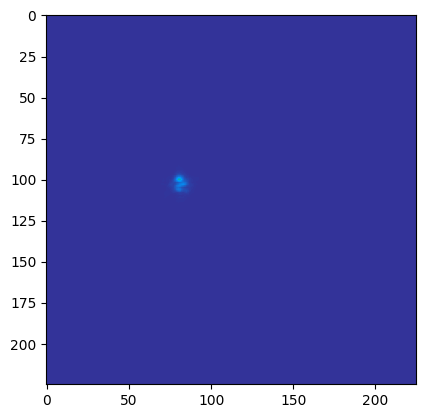

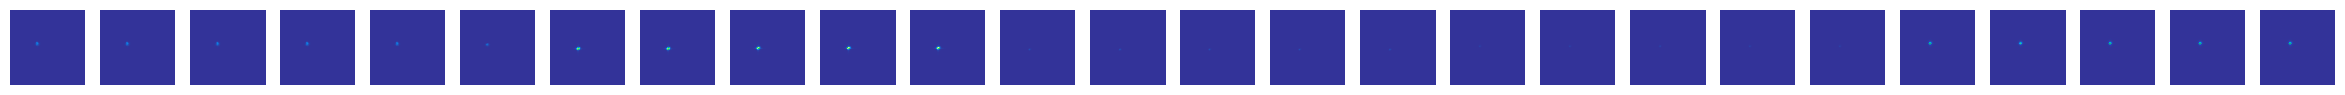

In [7]:
import matplotlib.colorbar as mcb
s1 = df
s1_train = s1.filter(pl.col('izero'))

full_ccd = np.array([np.frombuffer(i, dtype=np.uint16).reshape(s1['Size'][0]) for i in s1_train['Image']])

# find min an max values for the colorbar
vmin = np.min(full_ccd)
vmax = np.max(full_ccd)
cmp = "terrain"

plt.imshow(full_ccd[0], cmap=cmp, vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1, len(full_ccd), figsize=(30, 4.8))
for i in range(len(full_ccd)):
    ax[i].imshow(full_ccd[i], cmap=cmp, vmin=vmin, vmax=vmax)
    ax[i].axis('off')

In [14]:
import torch
import torchvision
from torchvision.transforms import functional as F

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        # Locate the max in the image, and place a bounding box around it
        max_val = np.max(img)
        max_idx = np.where(img == max_val)
        x1 = max_idx[1][0] - 5
        x2 = max_idx[1][0] + 5
        y1 = max_idx[0][0] - 5
        y2 = max_idx[0][0] + 5

        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)
        labels = torch.tensor([1] * len(boxes), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        if self.transform:
            img, target = self.transform(img, target)

        return img, target

import torchvision.models.detection

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model


In [15]:
num_classes = 2
num_epochs = 10
learning_rate = 0.005

model = get_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


c:\Users\hduva\.projects\pyref\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hduva\.projects\pyref\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
from torch.utils.data import DataLoader

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_data = CustomDataset(full_ccd, transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=2, shuffle=True, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

model.train()
for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item()}")

TypeError: ToTensor.__call__() takes 2 positional arguments but 3 were given

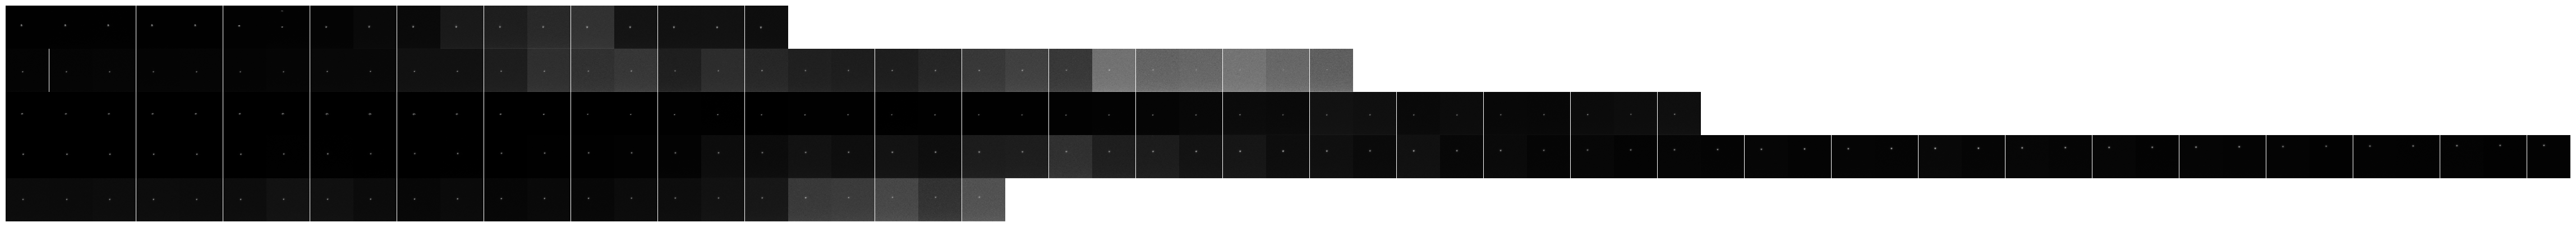

In [50]:
# Plot the data using matplotlib
# ncols is the max length of the Image column

ncols = max([len(x) for x in stitch['Image']])
nrows = len(stitch['Image'])

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (round(ncols), round(nrows)), gridspec_kw={'hspace': 0, 'wspace': 0})

for a in ax.flatten():
    a.axis('off')

for i in range(nrows):
    for j in range(len(stitch['Image'][i])):
        ax[i,j].imshow(np.frombuffer(stitch['Image'][i][j], dtype=np.uint16).reshape(stitch['Size'][i][j]), cmap='gray')

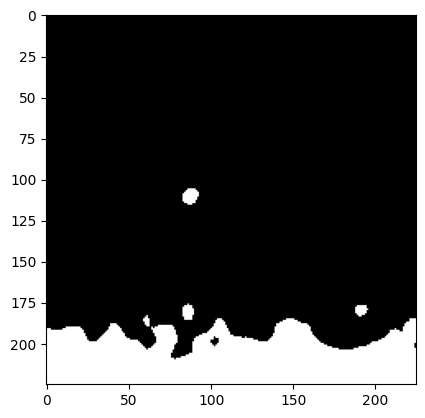

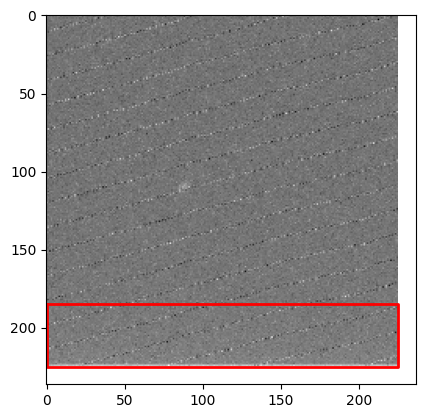

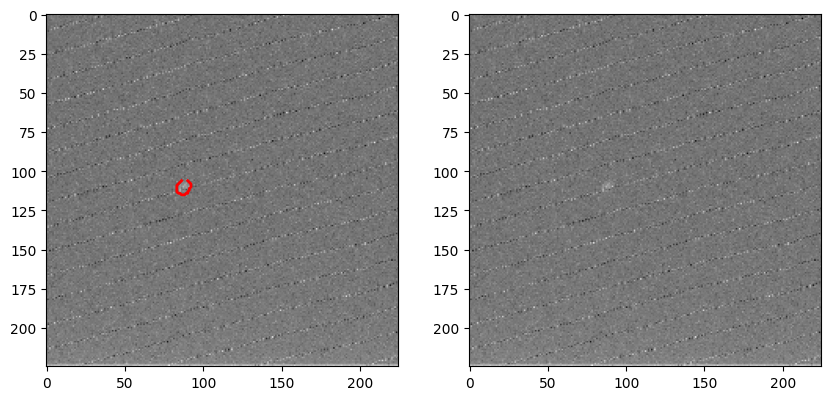

In [10]:
processed = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX).astype(
    np.uint8
)

# Apply a Gaussian blur to reduce noise
blurred_image = cv.GaussianBlur(processed, (25, 25), 0)
# Threshold the image to create a binary image
_, threshold_image = cv.threshold(
    blurred_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)#

plt.imshow(threshold_image, cmap='gray')
plt.show()

# find the contours from the threshold image
contours, _ = cv.findContours(
    threshold_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
)

largest_contour = None
largest_contour_area = 0
for contour in contours:
    contour_area = cv.contourArea(contour)
    if contour_area > largest_contour_area:
        largest_contour = contour
        largest_contour_area = contour_area

# Determine the bounding rectangle for the largest contour
x, y, w, h = cv.boundingRect(largest_contour)

# Display the image with the bounding rectangle
plt.imshow(image, cmap="gray")
plt.plot(
    [x, x + w, x + w, x, x], [y, y, y + h, y + h, y], "r", linewidth=2
)
plt.show()

# Display the raw contours
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image, cmap="gray")
ax[0].plot(contour[:, :, 0], contour[:, :, 1], 'r', linewidth=2)
ax[1].imshow(image, cmap="gray")
plt.show()

In [10]:
moments = cv.moments(largest_contour)
centroid_x = int(moments["m10"] / moments["m00"])
centroid_y = int(moments["m01"] / moments["m00"])
direct_beam = (centroid_x, centroid_y)
direct_beam

(81, 109)

In [11]:
mask = np.zeros_like(image)
cv.drawContours(mask, [largest_contour], 0, 255, -1)
masked_image = cv.bitwise_and(image, mask)

cv.imshow("Image", image)
cv.imshow("Processed", processed)
cv.imshow("Blurred Image", blurred_image)
cv.imshow("Threshold Image", threshold_image)
cv.imshow("Masked Image", masked_image)
cv.waitKey(0)

-1

# Rust

In [36]:
:dep astrors
:dep polars
:dep numpy
:dep plotters
:dep glob
:dep regex
:dep ndarray

In [48]:
use std::path::Path;
use std::fs::File;
use glob::glob;
use polars::prelude::*;
use regex::Regex;
use astrors::io;
use ndarray::Array2;

// Formats for Data that could be found in the experiment data directory
#[derive(Debug)]
enum DataFormat {
    Fits(Fits),
    Csv(Csv),
    Temp(Temp),
}

// Polarization of the data
#[derive(Debug)]
enum Pol {
    S,
    P,
    N,
}

// Structures to hold the data
#[derive(Debug)]
struct DataFile {
    id: SampleID,
    data: Option<DataFormat>,
}

#[derive(Debug)]
struct SampleID {
    name: String,
    scan_id: u32,
    file_id: u32,
}

#[derive(Debug)]
struct Fits {
    pol: Pol,
    energy: f64,
    current: f64,
    hos: f64,
    hes: f64,
    exposure: f64,
    image: f64,
    image: io::hdus::image::image::ImageData,
}

#[derive(Debug)]
struct Csv {}

#[derive(Debug)]
struct Temp {}

// Implementations for these data structures
impl DataFile {
    fn new(id: SampleID, data: Option<DataFormat>) -> Self {
        DataFile { id, data }
    }

    fn read_file(file: &str) -> Self {
        let file_name = Path::new(file).file_name().unwrap().to_str().unwrap();
        let (id, kind) = SampleID::parse_file_name(file_name);
        let data = match kind {
            "fits" => Some(DataFormat::Fits(Fits::from_file(file))),
            "csv" => Some(DataFormat::Csv(Csv::from_file(file))),
            "temp" => Some(DataFormat::Temp(Temp::from_file(file))),
            _ => None,
        };
        DataFile::new(id, data)
    }
}

impl SampleID {
    fn new(name: String, scan_id: u32, file_id: u32) -> Self {
        SampleID { name, scan_id, file_id }
    }

    fn parse_file_name(file_name: &str) -> (Self, &str) {
        if file_name.contains("Captured Image") {
            let parts: Vec<&str> = file_name.split("Captured Image ").collect();
            return (
                Self {
                    name: String::from("Capture"),
                    scan_id: parts[1].split(" ").collect::<Vec<&str>>()[1].parse::<u32>().unwrap(),
                    file_id: 0,
                },
                "temp",
            );
        } else {
            let re = Regex::new(r"([0-9]{5})-(\d+)\.fits$").unwrap();
            if let Some(caps) = re.captures(file_name) {
                let scan_id = caps.get(1).unwrap().as_str().to_string();
                let file_id = caps.get(2).unwrap().as_str().to_string();
                let sample_name = file_name.split(scan_id.as_str()).collect::<Vec<&str>>()[0]
                    .trim_end_matches('-')
                    .to_string();
                return (
                    Self {
                        name: sample_name,
                        scan_id: scan_id.parse().unwrap(),
                        file_id: file_id.parse().unwrap(),
                    },
                    "fits",
                );
            } else {
                panic!("Invalid file: {}", file_name);
            }
        }
    }
}

impl Fits {
    fn new(pol: Pol, energy: f64, current: f64, hos: f64, hes: f64, exposure: f64, theta: f64, image: io::hdus::image::image::ImageData) -> Self {
        Fits { pol, energy, current, hos, hes, exposure, theta , image }
    }

    fn from_file(file: &str) -> Self {
        let mut fits_file = File::open(file).unwrap();
        let mut header = io::Header::new();
        header.read_from_file(&mut fits_file)?;

        let image_hdu = io::hdus::image::image::ImageParser::read_from_buffer(&mut fits_file, &mut header)?;

        let pol_card = match header.get_card("EPU Polarization") {
            Some(card) => card.value.to_string(),
            None => String::from("N/A"),
        };
        let pol_state = match pol_card.as_str() {
            "100" => Pol::S,
            "190" => Pol::P,
            _ => Pol::N,
        };
        let energy = header.get_card("Beamline Energy").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let theta = header.get_card("Sample Theta").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let current = header.get_card("Beam Current").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let exposure = header.get_card("EXPOSURE").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let hos = header.get_card("Higher Order Suppressor").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let hes = header.get_card("Horizontal Exit Slit Size").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));

        let image = image_hdu.data;

        Fits::new(pol_state, energy, current, hos, hes, exposure, theta, image)
    }
}

impl Csv {
    fn new() -> Self {
        Csv {}
    }

    fn from_file(_file: &str) -> Self {
        Csv::new()
    }
}

impl Temp {
    fn new() -> Self {
        Temp {}
    }

    fn from_file(_file: &str) -> Self {
        Temp::new()
    }
}


Error: the `?` operator can only be used in a method that returns `Result` or `Option` (or another type that implements `FromResidual`)

Error: the `?` operator can only be used in a method that returns `Result` or `Option` (or another type that implements `FromResidual`)

Error: no field `data` on type `ImageData`

In [42]:
let file = r"C:\Users\hduva\pyref\src\refl\ZnPc82862-00001.fits";
let out = DataFile::read_file(file);

In [43]:
println!("{:#?}", out);

DataFile {
    id: SampleID {
        name: "ZnPc",
        scan_id: 82862,
        file_id: 1,
    },
    data: Some(
        Fits(
            Fits {
                pol: S,
                energy: 283.702099502383,
                current: 499.725799560547,
                hos: 8.79951333595377,
                hes: 3000.0,
                exposure: 0.00100000004749745,
                theta: 0.0,
                image: FitsData::U8([[190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190],
                 [11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82,